In [234]:
import matplotlib.pyplot as plt
import scipy
import sympy
import numpy as np
import control 
import os
import array_to_latex as a2l
from LatexGapFiller import LatexGapFiller, TextSheet
from ControlTheoryToolbox import System, CToolbox
import cvxpy

In [235]:
def task1_get_G(specs):
    new_g = np.diag(specs)
    for i in range(1, new_g.shape[0]):
        if new_g[i, i] == new_g[i-1, i-1]:
            new_g[i-1, i] = 1
    if specs[2].imag != 0:
        new_g[2, 2] = specs[2].real
        new_g[3, 3] = specs[2].real
        new_g[2, 3] = specs[2].imag
        new_g[3, 2] = -specs[2].imag
    return new_g

In [236]:
def task2_get_L(A, C, G, Y):
    Q = cvxpy.Variable(A.shape)
    objective = cvxpy.Minimize(cvxpy.sum_squares(G @ Q - Q @ A - Y @ C))
    prob = cvxpy.Problem(objective)
    print(f'Optimization error: {prob.solve()}, rankP = {np.linalg.matrix_rank(Q.value)}')
    return np.linalg.pinv(Q.value) @ Y, Q.value

In [237]:
A = np.array([
    [0, 7, 0, 0],
    [-7, 0, 0, 0],
    [0, 0, 0, 2],
    [0, 0, -2, 0],
])
C = np.array([
    [1, 0, 0, 6]
])
x0 = np.array([
    [1],
    [1],
    [1],
    [1]
])
xh0 = np.array([
    [2],
    [0],
    [0],
    [-1]
])
print(a2l.to_ltx(A, frmt = '{:2}', arraytype = 'bmatrix', print_out=False))
print(a2l.to_ltx(C, frmt = '{:2}', arraytype = 'bmatrix', print_out=False))

\begin{bmatrix}
   0  &   7  &   0  &   0 \\
 -7  &   0  &   0  &   0 \\
   0  &   0  &   0  &   2 \\
   0  &   0  & -2  &   0 
\end{bmatrix}
\begin{bmatrix}
   1  &   0  &   0  &   6 
\end{bmatrix}


In [238]:
print(np.linalg.eig(A)[0])
print(a2l.to_ltx(np.linalg.eig(A)[0], frmt = '{:2}', arraytype = 'bmatrix', print_out=False))
print(CToolbox.check_eigenvalues_observable(A, C))

[0.+7.j 0.-7.j 0.+2.j 0.-2.j]
\begin{bmatrix}
  0.0 + 7.000000000000001j &  0.0 + -7.000000000000001j &  0.0 + 2.0000000000000004j &  0.0 + -2.0000000000000004j
\end{bmatrix}
[ True  True  True  True]


In [239]:
desired_eigvalues = [-5, -10, -2+6j, -2-6j]
print(a2l.to_ltx(np.array(desired_eigvalues), frmt = '{:2}', arraytype = 'bmatrix', print_out=False))
G = task1_get_G(desired_eigvalues)
Y = np.array([
    [1],
    [1],
    [1],
    [1]
])
G, Y

\begin{bmatrix}
 -5.0 + 0.0j  & -10.0 + 0.0j  & -2.0 + 6.0j  & -2.0 + -6.0j 
\end{bmatrix}


(array([[ -5.+0.j,   0.+0.j,   0.+0.j,   0.+0.j],
        [  0.+0.j, -10.+0.j,   0.+0.j,   0.+0.j],
        [  0.+0.j,   0.+0.j,  -2.+0.j,   6.+0.j],
        [  0.+0.j,   0.+0.j,  -6.+0.j,  -2.+0.j]]),
 array([[1],
        [1],
        [1],
        [1]]))

In [240]:
print(a2l.to_ltx(G.astype(int), frmt = '{:2}', arraytype = 'bmatrix', print_out=False))
print(a2l.to_ltx(Y, frmt = '{:2}', arraytype = 'bmatrix', print_out=False))

\begin{bmatrix}
 -5  &   0  &   0  &   0 \\
   0  & -10  &   0  &   0 \\
   0  &   0  & -2  &   6 \\
   0  &   0  & -6  & -2 
\end{bmatrix}
\begin{bmatrix}
   1 \\
   1 \\
   1 \\
   1 
\end{bmatrix}


/tmp/ipykernel_47543/2772289852.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  print(a2l.to_ltx(G.astype(int), frmt = '{:2}', arraytype = 'bmatrix', print_out=False))


In [241]:
CToolbox.check_system_controllable(G, Y)

True

In [242]:
L, Q = task2_get_L(A, C, G, Y)
L

Optimization error: 2.908924588002481e-30, rankP = 4


array([[-2.91111111],
       [-9.36190476],
       [ 2.62222222],
       [-2.68148148]])

In [243]:
print(a2l.to_ltx(L, frmt = '{:2.2f}', arraytype = 'bmatrix', print_out=False))
print(a2l.to_ltx(Q, frmt = '{:2.2f}', arraytype = 'bmatrix', print_out=False))

\begin{bmatrix}
 -2.91\\
 -9.36\\
  2.62\\
 -2.68
\end{bmatrix}
\begin{bmatrix}
 -0.07 &  0.09 & -0.41 & -1.03\\
 -0.07 &  0.05 & -0.12 & -0.58\\
 -0.14 &  0.33 &  0.04 & -1.34\\
 -0.27 & -0.06 &  0.46 &  0.56
\end{bmatrix}


In [244]:
def task2_simulate(A, C, L, x0, xh0, time_end):
    ts = np.linspace(0, time_end, 1000)
    ss_orig = control.ss(A, np.zeros((A.shape[0], 1)), C, np.zeros((C.shape[0], 1)))
    original_resp = control.forced_response(ss_orig, X0=x0, T=ts)
    ss = control.ss(A + L@C, -L, A*0, L*0)
    return ts, original_resp, control.forced_response(ss, X0=xh0, T=ts, U=original_resp.outputs.reshape(-1))

In [245]:
ts, res_orig, res_observer = task2_simulate(A, C, L, x0, xh0, 4)

In [246]:
def modeling(res_orig, res_observer, ts):
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
    # colors = ['blue', 'r', 'green', 'orange']
    for i in range(4):
        ss = control.ss(A + L@C, L*0, A*0, L*0)
        original_resp = control.forced_response(ss, X0=x0-xh0, T=ts)
        
        axs[i // 2, i % 2].plot(ts, res_orig.states[i], linewidth=3, label=f"system", color='blue')
        axs[i // 2, i % 2].plot(ts, res_observer.states[i], linewidth=3, linestyle='--',label=f"observer", color='red')
        axs[i // 2, i % 2].plot(ts, original_resp.states[i], linewidth=2, linestyle='dashdot', label=f"error", color='green')
        axs[i // 2, i % 2].set_title(f'x = x_{i}(t)', fontsize=12)
        axs[i // 2, i % 2].set_xlabel(f"t, [c]", fontsize=12)
        axs[i // 2, i % 2].grid(True)
        axs[i // 2, i % 2].legend()
    
    # axs[1].plot(time, (K @ output).reshape(-1), linewidth=3, label=f"u(t)", color='r')
    # axs[1].set_title(f'u(t)', fontsize=12)
    # axs[1].set_xlabel(f"t, [c]", fontsize=12)
    # axs[1].grid(True)
    # axs[1].legend()

    # axs[1, 1].plot(t, np.array(U).reshape(-1), linewidth=4)
    # axs[1, 1].set_title(f'u = u(t)', fontsize=12)
    # axs[1, 1].set_xlabel(f"t, [c]", fontsize=12)
    # axs[1, 1].grid(True)

In [247]:
np.linalg.eig(A+L@C)[0]

array([ -2.+6.j,  -2.-6.j, -10.+0.j,  -5.+0.j])

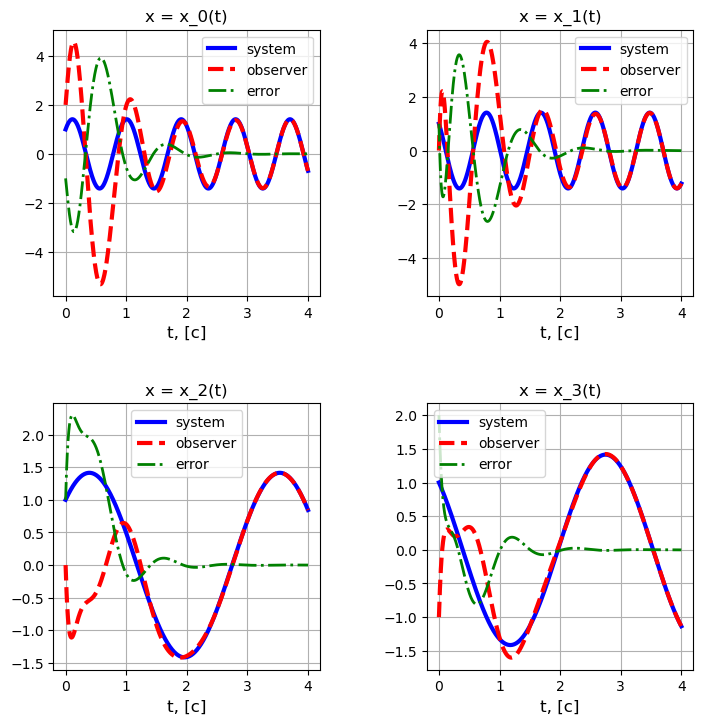

In [248]:
modeling(res_orig, res_observer, ts)